# **Hydropower constraint in PyPSA with Linopy**

This notebook uses a toy PyPSA model to showcase how hydropower dispatch can be bounded by the historical hydro operation. With this approach, we avoid that the bulk hydropower reservoir is operated in a too ideal manner caused by the year-ahead perfect foresight assumed in the model.

The toy model is a copper plate representation of the Norwegian electricity system. Hydropower capacity is included exogenously (Norway has a capacity of [37.7 GW](https://energifaktanorge.no/en/norsk-energiforsyning/kraftproduksjon/)) while wind and solar generation capacity are included endogenously, i.e., they are subject to optimization. Furthermore, as an electricity storage option, we make Li-Ion batteries available to be invested in.   

Capital costs used in this toy model do not represent real values but are solely used as exemplary data. The same applies to the considered scenario. The scenario is realized by assuming that the electricity load is increased by a factor 2 to force a capacity expansion. Secondly, we force the system to rely heavily on solar to introduce a large mismatch during winter. In this period, the perfect foresight of the model entails that hydropower reservoirs are discharged heavily, while the dispatch during summer is very low. To ensure that we do not interrupt with other non-energy system phenomena, e.g., water accesability and ecosystem flow continuity requirements, we need to constrain the dispatch.  

For a robust PyPSA-Eur implementation, the following things need to be made:
- Write the query code that fetches the ENTSO-E dispatch data (currently, this was manually downloaded and the recent years are for this reason not included)
- Create a Github repo that stores all historical dispatch data (it would be inconvenient if this was added directly to the PyPSA-Eur repo)
- Extend this jupyter notebook to account for multiple nodes within a country, i.e., historical data needs to be split and scaled (according to population/demand?) 

The capacity factors of solar and wind are acquired from the course in [Renewable Energy Systems](https://github.com/martavp/RES_project) taught by Marta Victoria. 

Import useful modules:

In [40]:
import pypsa
import pandas as pd
import numpy as np
import xarray as xr
import importlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yaml
import warnings
warnings.filterwarnings("ignore")

The following lines ensure continuous reloading of functions which is convenient in the editing stage:

In [2]:
%load_ext autoreload
%autoreload 2

Import functions:

In [3]:
from plotting import plot_layout, plot_historical_dispatch, plot_hydro_operation, plot_electricity_supply, plot_total_electricity_supply
from investment import annuity,build_base_network, solve_network

Standardize figure layout:

In [4]:
fs = 18
plot_layout(fs)
tech_colors_path = 'tech_colors.yaml'
with open(tech_colors_path) as file:
    tech_colors = yaml.safe_load(file)['tech_colors']

Pick a country (here, we consider Norway due to their high share of hydropower):

In [5]:
country = 'NOR'

country_iso_alpha2 = {'NOR':'NO'} # country codes
long_country_name = {'NOR':'Norway',
                    'SWE':'Sweden',
                    'AUT':'Austria'}
hydro_cap = {'NOR':37732} # the aggregate power capacity of each countries
hydro_max_hours = {'NOR':1129.7} # the max hours (duration), which implicitly defines the energy capacity, of the hydro reservoir

# **Historical inflow**

In [6]:
inflow_values = pd.read_csv('data/inflow/Hydro_inflow_' + country_iso_alpha2[country] + '.csv', sep=',', index_col=0)
hydro_dates = pd.date_range('1/1/2003','31/12/2012',freq='d')
inflow_series = pd.Series(index=hydro_dates,
                          data=inflow_values['Inflow [GWh]'].values)*1e3 # convert GWh to MWh
inflow_series_hourly = inflow_series.resample(rule='h').mean().interpolate(method='linear')/24

Available years:

In [7]:
print('Historical inflow years: ', list(inflow_series_hourly.index.year.unique()))

Historical inflow years:  [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]


Pick one of the year contained in the above list:

In [8]:
hydro_year = 2011
inflow_series_hourly_year = inflow_series_hourly.loc[inflow_series_hourly.index[inflow_series_hourly.index.year == hydro_year]]

# **Historical dispatch**

The question is, do we want to limit the hourly power generation or the aggregate energy production? We test this in the following.

Read historical data on hydro reservoir dispatch:

In [9]:
historical_dispatch = pd.read_csv('ENTSOE_data/dispatch_' + long_country_name[country] + '_2015-2018.csv',index_col=0)
historical_dispatch.index = pd.to_datetime(historical_dispatch.index)
df = pd.DataFrame(index=pd.date_range('1/1/2015','1/1/2016',freq='h',closed='left'))

Split data by year:

In [10]:
df1 = pd.DataFrame(historical_dispatch)
df1['year'] = df1.index.year
for year in df1.index.year.unique():
    df1_year = df1.query('year == @year')
    df1_year = df1_year[~df1_year.index.duplicated(keep='first')]
    
    if (year % 4 == 0) and (year % 100 != 0): # leap year    
        day_29 = df1_year.index.day == 29
        feb_29 = df1_year[day_29][df1_year[day_29].index.month == 2]
        df1_year = df1_year.drop(index=feb_29.index)
    
    df[year] = df1_year.disp.values

## Hourly dispatch

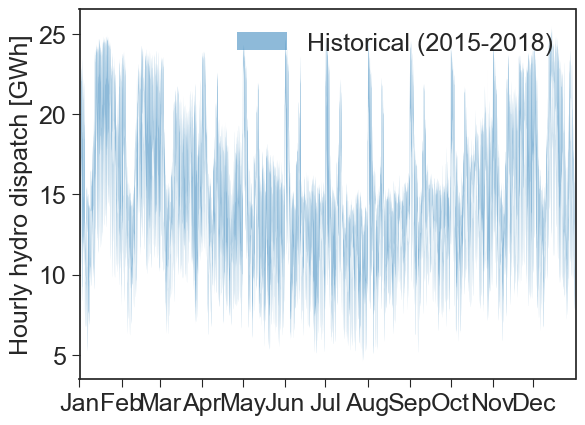

In [11]:
df_min = df.min(axis=1)
df_max = df.max(axis=1)

fig, ax = plt.subplots()
x = df_min.index
y1 = df_min
y2 = df_max
ax.fill_between(x,y1,y2,alpha=0.5,label='Historical (2015-2018)')

ax.set_xlim(min(x),max(x))
ax.legend()
ax.set_ylabel('Hourly hydro dispatch [GWh]')

fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(fmt);

We do see a seasonal trend. However, note that peak dispatch power is observed troughout the year. Althouh low dispatch is observed on average during summer, hours with full utilization of the hydropower capacity is still observed in this period. From this observation, we learn that **we should not constrain the hourly dispatch**.

We can check this for other countries (to do so, uncomment the below line), here exemplified with Sweden:

In [ ]:
# plot_historical_dispatch('SWE',long_country_name,freq='h')

## Monthly aggregate dispatch

Instead of looking at hourly dispatch, let's consider the monthly aggregate. Here, we illustrate the historical band of the dispatch based on monthly aggregate:

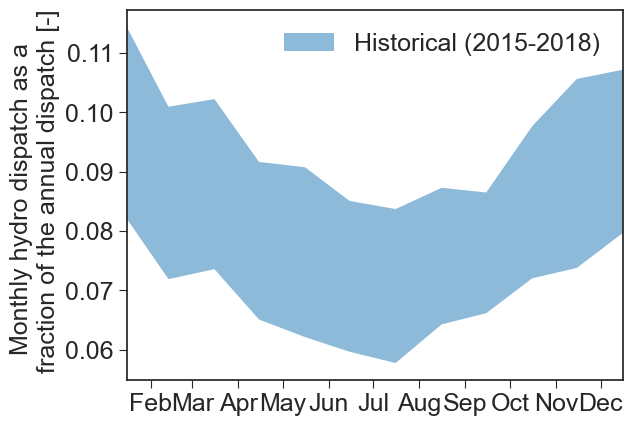

In [12]:
df_min = df.min(axis=1)
df_max = df.max(axis=1)

fig, ax = plt.subplots()
x = df_min.resample('m').sum().index - pd.Timedelta('15d')
y1 = df_min.resample('m').sum()/(df.mean(axis=1).resample('m').sum().sum())
y2 = df_max.resample('m').sum()/(df.mean(axis=1).resample('m').sum().sum())

ax.fill_between(x,y1,y2,alpha=0.5,label='Historical (2015-2018)')
ax.set_xlim(min(x),max(x))
ax.legend()
ax.set_ylabel('Monthly hydro dispatch as a \n fraction of the annual dispatch [-]')

fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(fmt);

By using the monthly aggregate, we can constrain the hydropower more realistically to retain the historical seasonality - and we still allow hours with peak power production during summer. 

# **Investment optimization**

## Create network

Initialize network:

In [13]:
n = pypsa.Network()

Add buses (here, an electricity bus):

In [14]:
n.add("Bus","electricity bus")

Add carriers:

In [15]:
carriers = ['wind','solar','hydro','battery']
n.madd("Carrier",carriers);

Add time snapshots:

In [16]:
hours = pd.date_range('2015-01-01T00:00Z','2015-12-31T23:00Z', freq='H')
n.set_snapshots(hours)

Add load:

Let's assume the case at which Norway increses its electricity demand by a factor of 2. Otherwise, no capacity expansion would take place since hydro can cover all the load.

In [17]:
load_csv = 'data/electricity_demand.csv'
load = pd.read_csv(load_csv, sep=';', index_col=0)
load.index = pd.to_datetime(load.index)
load_scale_up = 2
n.add('Load', # pypsa component
      'el_load', # name
      bus = 'electricity bus', # bus name
      p_set = load[country]*load_scale_up
     )

# Add generators and storage

Let's force the system to have more solar than wind. In this way, without a hydropower constraint, the system chooses to have high hydro dispatch during winter to overcome the concurrently low availability of solar energy. As mentioned in the introduction, this does not represent any real scenario but is more a "model trick" to showcase an example. 

In [18]:
p_nom_wind  = 0
p_nom_solar = 0
p_nom_max_wind = 10e3
p_nom_max_solar = 10e5

## *Wind* (added endogenously)

Capacity factors:

In [19]:
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]

Add generator:

In [20]:
n.add('Generator',
      'wind',
      bus='electricity bus',
      carrier='wind',
      p_nom = p_nom_wind,
      p_nom_extendable=True,
      p_nom_max=p_nom_max_wind, # maximum capacity can be limited due to environmental constraints
      capital_cost=1e6*annuity(30,0.07),
      marginal_cost=0.015,
      p_max_pu=CF_wind,
     )

## *Solar* (added endogenously)

Capacity factors:

In [21]:
df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]

Add generator:

In [22]:
n.add('Generator',
      'solar',
      bus='electricity bus',
      carrier='solar',
      p_nom = p_nom_solar,
      p_nom_extendable=True,
      p_nom_max=p_nom_max_solar, # maximum capacity can be limited due to environmental constraints
      capital_cost=1e5*annuity(30,0.07),
      marginal_cost=0.01,
      p_max_pu=CF_solar,
     )

## *Hydro reservoir* (added exogenously) 

In [23]:
inflow_series_hourly_year.index = n.snapshots
hydro_inflow = inflow_series_hourly_year

In [24]:
n.add('StorageUnit',
      'hydro',
      bus='electricity bus',
      carrier = 'hydro',
      p_nom_extendable=False,
      p_nom=hydro_cap[country],
      inflow=hydro_inflow,
      max_hours=hydro_max_hours[country],
      capital_cost=10e6*annuity(30,0.07),
      marginal_cost=0.,
      p_max_pu=1, 
      p_min_pu=0, 
      efficiency_dispatch=0.9,
      efficiency_store=0.0, # you can't store electricity in this item
      cyclic_state_of_charge=True,
     )

## *Li-Ion battery* (added endogenously) 

In [25]:
n.add('StorageUnit',
      'battery',
      bus='electricity bus',
      carrier = 'battery',
      p_nom_extendable=True,
      capital_cost=1e6*annuity(30,0.07),
      max_hours=6,
      efficiency_store=0.95,
      efficiency_dispatch=0.95,
      cyclic_state_of_charge=True
     )

# **Results for an <u> unconstrained </u> hydro operation** 

It is a good idea to check if the network is built consistently. This can be done with the PyPSA function "consistency_check". From the PyPSA documentation: 
    
"Checks the network for consistency; e.g. that all components are connected to existing buses and that no impedances are singular.

Prints warnings if anything is potentially inconsistent."

In [26]:
n.consistency_check()

No output means that no inconsistencies are present. Them, we can proceed solving the network:

In [27]:
solve_network(n)

INFO:investment:No expandable lines found. Skipping iterative solving.
INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 4
 - method: 2
 - crossover: 0
 - BarConvTol: 1e-06
 - Seed: 123
 - AggFill: 0
 - PreDual: 0
 - GURO_PAR_BARDENSETHRESH: 200
 - seed: 10
Writing variables.: 100%|████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 49.23it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-22


Read LP format model from file C:\Users\au485969\AppData\Local\Temp\linopy-problem-chamedfy.lp
Reading time = 0.38 seconds
obj: 166445 rows, 78843 columns, 302854 nonzeros
Set parameter Threads to value 4
Set parameter Method to value 2
Set parameter Crossover to value 0
Set parameter BarConvTol to value 1e-06
Set parameter Seed to value 123
Set parameter AggFill to value 0
Set parameter PreDual to value 0
Set parameter GURO_PAR_BARDENSETHRESH to value 200
Set parameter Seed to value 10
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 4 threads

Optimize a model with 166445 rows, 78843 columns and 302854 nonzeros
Model fingerprint: 0x9a5e71fe
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  Objective range  [1e-02, 8e+04]
  Bounds range     [4e+03, 4e+04]
  RHS range        [4e+03, 4e+07]
Presolve removed 100116 rows

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78843 primals, 166445 duals
Objective: 7.26e+09
Solver model: available
Solver message: 2



PyPSA Network
Components:
 - Bus: 1
 - Carrier: 4
 - Generator: 2
 - Load: 1
 - StorageUnit: 2
Snapshots: 8760

In [28]:
model_monthly_dispatch = n.storage_units_t.p['hydro'].resample('m').sum()/1e3
historical_monthly_dispatch_min = df.resample('m').sum().min(axis=1)
historical_monthly_dispatch_max = df.resample('m').sum().max(axis=1)

Hydropower operation:

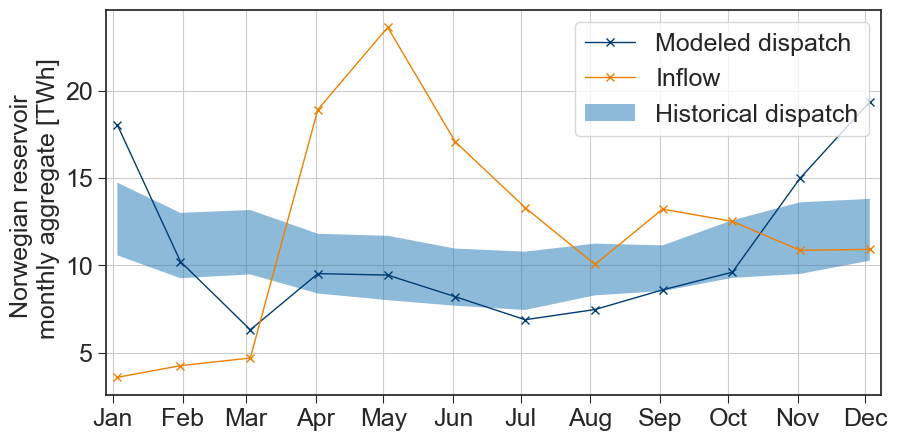

In [31]:
plot_hydro_operation(n,
                     df,
                     hydro_inflow,
                     freq='m'
                    )

At a high share of solar, the modeled dispatch exceeds the historical region. This is in line with the findings in [Gøtske and Victoria (2022)](https://doi.org/10.1016/j.isci.2021.102999).

Wind and solar power supply + battery balance:

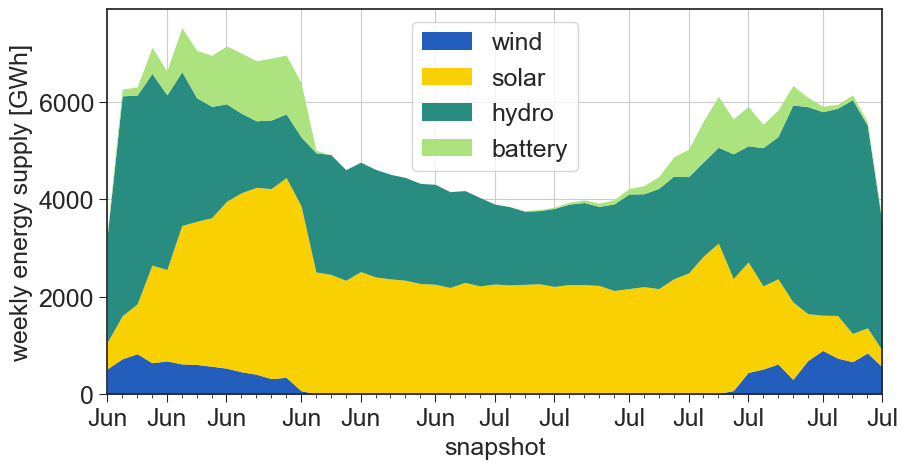

In [32]:
plot_electricity_supply(n,
                   tech_colors,
                   freq='w')

Annual electricity supply:

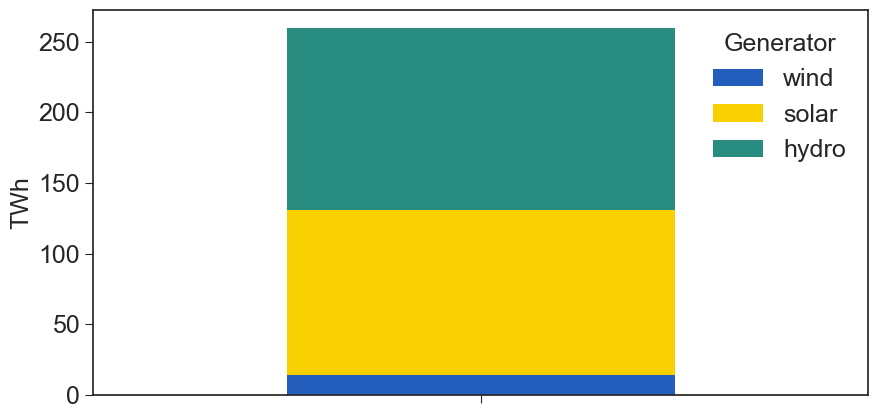

In [33]:
plot_total_electricity_supply(n,tech_colors)

# **Results for a <u> constrained </u> hydro operation** 

The following 'build_base_network' repeats the commands in the above, i.e., build network, add generators and storage units, etc.:

In [141]:
n = build_base_network(country,
                       load_csv,
                       load_scale_up,
                       CF_wind,
                       p_nom_wind,
                       p_nom_max_wind,
                       CF_solar,
                       p_nom_solar,
                       p_nom_max_solar,
                       carriers_list=['wind','solar','battery'])

In [ ]:
# Let's define the upper and lower bound:
#df_min_2 = df_min.resample('m').min() # gives you the hourly minimum within the considered month
#df_min_2_hourly = df_min_2.resample(rule='h').mean().interpolate(method='linear')

We also import the reservoir fill level to add initial fill level in each reservoir:

In [199]:
#reservoir_fill_level = pd.read_csv('ENTSOE_data/reservoir_fill_level_Norway.csv')
#reservoir_fill_level.columns = ['week','2015','2016','2017','2018']
#df_res_level = reservoir_fill_level.drop(columns=['week']).astype(float)
#df_res_level = (df_res_level.fillna(method='ffill') + df_res_level.fillna(method='bfill'))/2
#df_res_level = df_res_level.drop(index=52)

In [200]:
#all_max = df.max().max()
#df_min = df.min(axis=1)
#df_max = df.max(axis=1)

#hydro_min_constraint = df_min/all_max*0.2
#hydro_max_constraint = df_max/all_max

In [201]:
#hydro_min_constraint.index = n.snapshots
#hydro_max_constraint.index = n.snapshots

In [202]:
#min_df = pd.Series(index=n.snapshots,data=[0.]*8760)
#max_df = pd.Series(index=n.snapshots,data=[1.]*8760)

In [142]:
n.add('StorageUnit',
      'hydro',
      bus='electricity bus',
      carrier = 'hydro',
      p_nom_extendable=False,
      p_nom=hydro_cap[country],
      inflow=hydro_inflow,
      max_hours=hydro_max_hours[country],
      capital_cost=10e6*annuity(30,0.07),
      marginal_cost=0.,
      p_max_pu=1, 
      p_min_pu=0,
      efficiency_dispatch=0.9,
      efficiency_store=0.0, # you can't store electricity in this item
      cyclic_state_of_charge=True,
      #state_of_charge_initial = df_res_level.loc[0].min()
     )

Now we proceed with accesing the linopy interface to add the constraints. First, we create the model interface: 

In [148]:
m = n.optimize.create_model()

From this, we can find variables and constraint definitions.

In [171]:
lhs

LinearExpression:
-----------------
1.0 Generator-p[2015-01-01 00:00:00+00:00, wind] + 1.0 Generator-p[2015-01-01 01:00:00+00:00, wind] + 1.0 Generator-p[2015-01-01 02:00:00+00:00, wind] ... 1.0 Generator-p[2015-12-31 21:00:00+00:00, wind] + 1.0 Generator-p[2015-12-31 22:00:00+00:00, wind] + 1.0 Generator-p[2015-12-31 23:00:00+00:00, wind]

In [179]:
from investment import rolling_sum

In [199]:
m_wind_data = m.variables["Generator-p"].sel(Generator='wind').data

In [200]:
m_wind_data['snapshot'] = pd.DatetimeIndex(m_wind_data['snapshot'].values)

In [202]:
m_wind_data.resample(snapshot='m').sum()

<xarray.DataArray 'Generator-p' (snapshot: 12)>
array([  555024,  1452864,  2662032,  3630240,  4840464,  5738400,
        7018896,  8125968,  8917920, 10304400, 11026080, 12482832])
Coordinates:
    Generator  <U4 'wind'
  * snapshot   (snapshot) datetime64[ns] 2015-01-31 2015-02-28 ... 2015-12-31
Attributes:
    binary:   False
    integer:  False

In [204]:
xr_data = m.variables["StorageUnit-p_dispatch"].sel(StorageUnit='hydro').data
xr_data['snapshot'] = pd.DatetimeIndex(xr_data['snapshot'].values)
lhs = xr_data.resample(snapshot='m').sum()

In [222]:
rhs = np.arange(8760) # <----- The current issue is to have the "rhs" as an array

If we were allowed to have "rhs" as a vector, this would be easily solved.

In [227]:
lhs

LinearExpression (snapshot: 8760):
----------------------------------
[2015-01-01 00:00:00+00:00]: 1.0 Generator-p[2015-01-01 00:00:00+00:00, wind]
[2015-01-01 01:00:00+00:00]: 1.0 Generator-p[2015-01-01 00:00:00+00:00, wind] + 1.0 Generator-p[2015-01-01 01:00:00+00:00, wind]
[2015-01-01 02:00:00+00:00]: 1.0 Generator-p[2015-01-01 00:00:00+00:00, wind] + 1.0 Generator-p[2015-01-01 01:00:00+00:00, wind] + 1.0 Generator-p[2015-01-01 02:00:00+00:00, wind]
[2015-01-01 03:00:00+00:00]: 1.0 Generator-p[2015-01-01 00:00:00+00:00, wind] + 1.0 Generator-p[2015-01-01 01:00:00+00:00, wind] + 1.0 Generator-p[2015-01-01 02:00:00+00:00, wind] + 1.0 Generator-p[2015-01-01 03:00:00+00:00, wind]
[2015-01-01 04:00:00+00:00]: 1.0 Generator-p[2015-01-01 00:00:00+00:00, wind] + 1.0 Generator-p[2015-01-01 01:00:00+00:00, wind] + 1.0 Generator-p[2015-01-01 02:00:00+00:00, wind] + 1.0 Generator-p[2015-01-01 03:00:00+00:00, wind] + 1.0 Generator-p[2015-01-01 04:00:00+00:00, wind]
[2015-01-01 05:00:00+00:00]: 1

In [221]:
kwargs = {'snapshot':30*24}
lhs = m.variables["Generator-p"].sel(Generator='wind').rolling_sum(**kwargs)
m.add_constraints(lhs <= rhs, name="hydro seasonality constraint3")

ValueError: Added data contains non-customized dimension names. This is not allowed when setting `force_dim_names` to True.

In [149]:
xr_data = m.variables["StorageUnit-p_dispatch"].sel(StorageUnit='hydro').data
xr_data['snapshot'] = pd.DatetimeIndex(xr_data['snapshot'].values)
lhs = xr_data.resample(snapshot='m').sum()

In [65]:
#buses = n.generators.bus.to_xarray()

In [90]:
#storage_carriers = n.storage_units.carrier.to_xarray()

In [109]:
#m.variables["StorageUnit-p_dispatch"].groupby(storage_carriers).sum().rolling_sum()

In [110]:
#m.variables["StorageUnit-p_dispatch"].sel(StorageUnit='hydro').sum().shape

In [111]:
#m.variables["Generator-p"].sel(Generator='wind').sum("snapshot")

In [129]:
#kwargs = {'time':10}
#m.variables["StorageUnit-p_dispatch"].sel(StorageUnit='hydro').rolling_sum(**kwargs)

In [112]:
# Use this information below!!!!!

# This one here 
#lhs = model.variables["Generator-p"].sel(Generator='Oil_generator').sum()
# This one here

#model.add_constraints(lhs <= oil_max_MWh*oil_conv_efficiency, name="oil total")

#IES.optimize.solve_model()

In [113]:
#lhs = model.variables["StorageUnit-p_dispatch"].sel(StorageUnit='hydro').sum("snapshot")

In [114]:
#storage_units_carriers = n.storage_units.carrier.to_xarray()
#prod_per_bus = m.variables["StorageUnit-p_dispatch"].groupby(storage_units_carriers).sum()

In [115]:
#m.variables["StorageUnit-p_dispatch"].groupby_sum(storage_units_carriers)

In [116]:
#dir(m.variables["StorageUnit-p_dispatch"])

In [117]:
#m.variables["StorageUnit-p_dispatch"]

In [118]:
#prod_per_bus

In [119]:
#total_demand

In [120]:
#m.variables["Generator-p"].groupby(buses).sum().sum("snapshot")

In [121]:
#m.variables['StorageUnit-p_dispatch','battery']

In [122]:
#m.variables["StorageUnit-state_of_charge"]

In [123]:
#m = n.optimize.create_model()
#sus = m.variables["StorageUnit-state_of_charge"]
#m.add_constraints(sus >= 50, name="StorageUnit-minimum_soc")

In [124]:
#hydro_index_bool = n.storage_units.index.str.contains("hydro")

In [125]:
#hydro_index = n.storage_units[hydro_index_bool].index

In [126]:
#type(n.model.variables['StorageUnit-p_dispatch'])

In [143]:
# m.constraints

In [144]:
n.consistency_check()

In [145]:
solve_network(n)

INFO:investment:No expandable lines found. Skipping iterative solving.
INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 4
 - method: 2
 - crossover: 0
 - BarConvTol: 1e-06
 - Seed: 123
 - AggFill: 0
 - PreDual: 0
 - GURO_PAR_BARDENSETHRESH: 200
 - seed: 10
Writing variables.: 100%|████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 43.01it/s]


Read LP format model from file C:\Users\au485969\AppData\Local\Temp\linopy-problem-7lptdknn.lp
Reading time = 0.48 seconds
obj: 166446 rows, 78843 columns, 311614 nonzeros
Set parameter Threads to value 4
Set parameter Method to value 2
Set parameter Crossover to value 0
Set parameter BarConvTol to value 1e-06
Set parameter Seed to value 123
Set parameter AggFill to value 0
Set parameter PreDual to value 0
Set parameter GURO_PAR_BARDENSETHRESH to value 200
Set parameter Seed to value 10
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 4 threads

Optimize a model with 166446 rows, 78843 columns and 311614 nonzeros
Model fingerprint: 0xa65336b5
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  Objective range  [1e-02, 8e+04]
  Bounds range     [4e+03, 4e+04]
  RHS range        [1e+03, 4e+07]
Presolve removed 100116 rows

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78843 primals, 166446 duals
Objective: 1.00e+10
Solver model: available
Solver message: 2



PyPSA Network
Components:
 - Bus: 1
 - Carrier: 3
 - Generator: 2
 - Load: 1
 - StorageUnit: 2
Snapshots: 8760

In [146]:
n.generators_t.p.sum()

Generator
wind     9.999996e+02
solar    1.320276e+08
dtype: float64

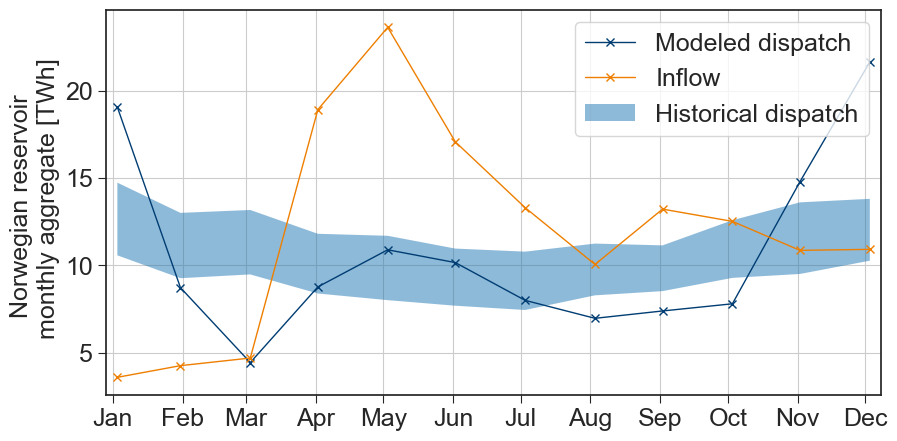

In [147]:
plot_hydro_operation(n,
                     df,
                     hydro_inflow,
                     freq='m'
                    )